## Importing libraries

In [16]:
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Web scraping from: https://wine.com
**The url_constructor function takes a page number and a URL as input, and it returns a new URL by splitting the original URL around the string**

In [17]:
def url_contructor(page_number, url):
    first = url.split('7155', 1)[0]
    second = url.split('7155',1)[1]
    url = first + '7155/' + str(page_number) + second
    return url

**The web_scrap function is a web scraper that collects data from a website that displays information about wine products.**

In [18]:
def web_scrap():
    page = 0
    url_df = []
    web_data = {'product_name': [],
                'year': [],
                'varietal': [],
                'origin': [],
                'price': [],
                'abv': [],
                'rating': [],
                'rating_count': [],
                'reviews': []
                }
    df = pd.DataFrame(data=web_data)
    url = 'https://www.wine.com/list/wine/7155?pricemin=10&ratingmin=89'
    for x in range(1, 150):
        try:
            page += 1
            url_df.append(url_contructor(page, url))
        except Exception:
            continue
    for link in tqdm(url_df):
        r = requests.get(link)
        soup = BeautifulSoup(r.content, 'html.parser')
        all_li = soup.find_all('li', {'class': 'prodItem'})
        for li in all_li:
            try:
                product_name = li.find('span', class_='prodItemInfo_name').string
                year = product_name.split()[-1]
                product_name = product_name.rsplit(' ', 1)[0]
                price = li.find('span', class_='productPrice_price-regWhole').string
                varietal = li.find('span', class_='prodItemInfo_varietal').string
                origin = li.find('span', class_='prodItemInfo_originText').string
                origin = origin.split()[-1]
                rating = li.find('span', class_='averageRating_average').string
                rating_count = li.find('span', class_='averageRating_number').string
                wine_link = li.find('a', class_='prodItemInfo_link event_productClick')
                wine_link = wine_link['href'].strip("'")
                r2 = requests.get(f'https://www.wine.com{wine_link}')
                soup2 = BeautifulSoup(r2.content, 'html.parser')
                abv = soup2.find('span', class_='prodAlcoholPercent_percent').string
                reviews = soup2.find_all('div', class_='pipProfessionalReviews_list')
                notes = ""
            except Exception:
                break
            for review in reviews:
                try:
                    rev = review.find('div', class_ ='pipSecContent_copy').string
                    if rev != None:
                        notes+= rev + " "
                except Exception:
                    break
            series = [product_name, year, varietal, origin, price, abv, rating, rating_count, notes]
            df.loc[len(df)] = np.asarray(series, dtype=object)
    return df

**Run this command to update the DataFrame**

In [19]:
#df = web_scrap()

**Run this command to save the DataFrame**

In [20]:
#df.to_csv('wine.csv')

**Load the DataFrame**

In [21]:
df = pd.read_csv('wine.csv', index_col=0)
df

,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews
0,Dom Perignon Vintage with Gift Box,2012,Vintage Sparkling Wine,France,269,12.0,4.8,49,What a magnificent bouquet for this Dom Pérign...
1,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,80,COMMENTARY: The 2019 Duckhorn Vineyards Cabern...
2,Veuve Clicquot Yellow Label,Brut,Non-Vintage Sparkling Wine,France,69,12.0,4.5,1745,"Toasty and generous with lemon freshness, this..."
3,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,15,The purity of fruit is really something else h...
4,Silver Oak Alexander Valley Cabernet Sauvignon,2018,Cabernet Sauvignon,California,89,14.4,4.7,29,"COMMENTARY: The Silver Oak Alexander Valley, o..."
...,...,...,...,...,...,...,...,...,...
3687,Bodegas Lavia Monastrell-Syrah,2017,Rhone Red Blends,Spain,18,14.5,3.4,5,The eponymous 2017 Lavia has more Monastrell t...
3688,Gianni Brunelli Rosso di Montalcino,2019,Sangiovese,Italy,44,0.0,0.0,0,A blend of Sangiovese grapes from Podernovone ...
3689,Cadence Cara Maria Vineyard Bel Canto,2018,Bordeaux Red Blends,Washington,64,14.4,0.0,0,"For decades, winemaker Ben Smith has had a lov..."
3690,Rutini Encuentro Malbec,2019,Malbec,Argentina,19,0.0,0.0,0,"Spicy, brambly fruit with some roasted sesame ..."


# Cleaning data for plots and machine learning

**Display the entire 'reviews' column**

In [22]:
with pd.option_context('display.max_colwidth', -1):
    display(df[['reviews']])

,reviews
0,"What a magnificent bouquet for this Dom Pérignon 2012! Pastry, a hint of smoke and autolytic notes provide a compelling counterpart to eager yet elegant aromas of citrus (lime, tangerine and kumquat) joined by those of fresh fruit, herbs, liquorice, and menthol. There is even a refreshing note of ivy. The palate is tense, vibrant, and very fresh despite its impressive density, which meets its match with an unending finish. This 2012 incarnates the very essence of Dom Pérignon with such a concentrated degree of intensity, along with a capacity for ageing, that it is surely destined for a second life in a P2 edition. Wonderful elegance and balance to this Dom Pérignon with cooked apple, lemon and hints of white pepper and salt. It’s medium-bodied with really fine bubbles and balance. Spicy at the end. So wonderfully fresh, linear and long. Racy and elegant. A DP that invites to drink right now. All about finesse. Tension, too, with precise phenolics and bright acidity on the back palate. Subtle energy. Drinkable now, but will develop beautifully in the bottle. This eloquent Champagne has an enticing waft of Mandarin orange on the nose that continues on the palate, which is layered with flavors of crushed blackberry and cassis, toast, chopped almond, graphite and oyster shell. A bright, finely-knit and harmonious version, with a lovely, raw silk-like mousse, and a lasting, expressive finish. Drink now through 2037. The 2012 Dom Pérignon has turned out very well indeed, unwinding in the glass with notes of Anjou pear, smoke, toasted nuts, freshly baked bread and crisp stone fruit. Medium to full-bodied, deep and concentrated, it's still tightly wound, its incipiently fleshy core of fruit framed by racy acids and chalky grip, complemented by a classy pinpoint mousse. A touch drier and a touch less reductive than the 2008 out of the gates, these two vintages are clearly destined to be compared for some time to come; but at this early stage, my instinct is that the 2012 will have the edge in the long term."
1,"COMMENTARY: The 2019 Duckhorn Vineyards Cabernet Sauvignon is lovely and shows excellent staying power on the palate. TASTING NOTES: This wine offers beautiful aromas and flavors of ripe cherries, black fruits, and complimentary oak nuances. Try it with a grilled, well-marbled ribeye. (Tasted: December 28, 2021, San Francisco, CA) Aromas of wet stone, gravel and blackcurrant. Full-bodied with fine, velvety tannins. Juicy, bright and fresh. Lovely dark fruit, with gravel and wet-stone notes adding very nice definition. Chocolate finish. A ripe, polished and direct style, with cassis, blackberry and red cherry puree gliding through, inlaid with light mocha and vanilla accents through the finish. Drink now"
2,"Toasty and generous with lemon freshness, this also has quite some dried-pear and peach aromas from mature elements of the blend, plus a touch of spice at the long, structured finish. The cuvée is based on 2015 and is 50% pinot noir, 30% chardonnay and 20% pinot meunier. Reserve wines make up more than one third of the blend. Drink now. Noticeable fruit intensity and fresh notes of red fruits, fresh blueberries and a small amount of quince. Interesting and quite demanding. Blend : 55% Pinot Noir, 15% Pinot Meunier, 30% Chardonnay One of the most popular of all Champagnes, this is now showing a freshness that wasn't always there. The crisp texture and green-apple flavors give it an immediate drinkability as well as perfumed acidity and a vibrant aftertaste. A crisp and lacy Champagne, with a hint of smoke underscoring flavors of poached apricot, pastry cream and pickled ginger. An overtone of Mandarin orange peel ties it all together."
3,"The purity of fruit is really something else here, with currants and fresh flowers, such as violets and roses. Flower stems as well. Fantastic length and structure to the wine, with tightness and focus. Wonderful fruit. Graceful. A blend of 78% cabernet sauvignon, 8% merlot, 7% p

**Droping all rows in the DataFrame where the "reviews" column is null**

In [23]:
df['reviews'] = df['reviews'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

In [24]:
df['reviews'] = df['reviews'].apply(lambda x: x if x else None)
df = df.dropna(subset=['reviews'])

**Removing any rows where the value in the rating and abv columns is 0, and then it removes any rows where the value in the rating_count column is less than or equal to 8**

In [25]:
df = df[df['rating'] != 0]
df = df[df['abv'] != 0]
df = df[df['rating_count'] > 8]

**The code performs several transformations on the DataFrame**  

In [26]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
df['price']=df['price'].str.replace(',','')
df = df.astype({'price':'int'})
df = df.astype({'rating':'float'})
df['year'] = pd.to_numeric(df['year'])

**The code filters the DataFrame df by removing any rows where the value in the year column is less than or equal to 2000 or greater than or equal to 2021** 

In [27]:
df = df[df['year'] > 2000]
df = df[df['year'] < 2021]
df = df.reset_index(drop=True)

**Filter the DataFrame by removing any rows where the value in the varietal column does not appear in at least three other rows, and then remove any rows where the value in the origin column does not appear in at least three other rows**

In [28]:
df = df.groupby('varietal').filter(lambda x : len(x)>2).reset_index(drop=True)
df = df.groupby('origin').filter(lambda x : len(x)>2).reset_index(drop=True)

**Remove duplicates**

In [29]:
df = df.drop_duplicates(subset=['product_name'])

**Add two new columns to the DataFrame, called varietal_code and origin_code, which contain integer codes that represent the values in the varietal and origin columns, respectively**

In [30]:
df['varietal_code'] = df['varietal'].astype('category').cat.codes
df['origin_code'] = df['origin'].astype('category').cat.codes
df = df.reset_index(drop=True)
df

,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews,varietal_code,origin_code
0,Dom Perignon Vintage with Gift Box,2012,Vintage Sparkling Wine,France,269,12.0,4.8,49,what a magnificent bouquet for this dom pérign...,28,5
1,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,80,commentary the 2019 duckhorn vineyards caberne...,4,3
2,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,15,the purity of fruit is really something else h...,1,3
3,Silver Oak Alexander Valley Cabernet Sauvignon,2018,Cabernet Sauvignon,California,89,14.4,4.7,29,commentary the silver oak alexander valley one...,4,3
4,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,82,14.5,4.4,91,cassis dried blueberries violets ink graphite ...,4,3
...,...,...,...,...,...,...,...,...,...,...,...
604,Vinaceous Reverend V Chardonnay,2016,Chardonnay,Australia,24,13.0,3.8,14,the team behind this brand including the winem...,6,2
605,J Wilkes Pinot Noir,2018,Pinot Noir,California,29,13.5,3.9,11,lastly the 2018 pinot noir j wilkes santa mari...,19,3
606,Masut Estate Vineyard Pinot Noir,2017,Pinot Noir,California,39,14.5,3.6,10,lithe pure and richtasting with concentrated d...,19,3
607,Tenuta di Nozzole Villa Nozzole Chianti Classico,2018,Sangiovese,Italy,21,13.6,3.7,9,a fresh lively red with plums tile and hints o...,22,7


**---------------------------------------------------------------------------------------------------------------------------**

# Plotting some usefull info 

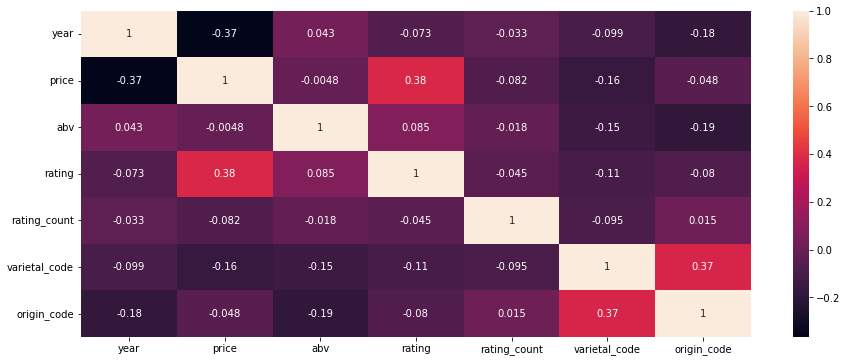

In [31]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()

### We can see a correlation between the origin and the variety of the wine, and also a correlation between the price and the rating

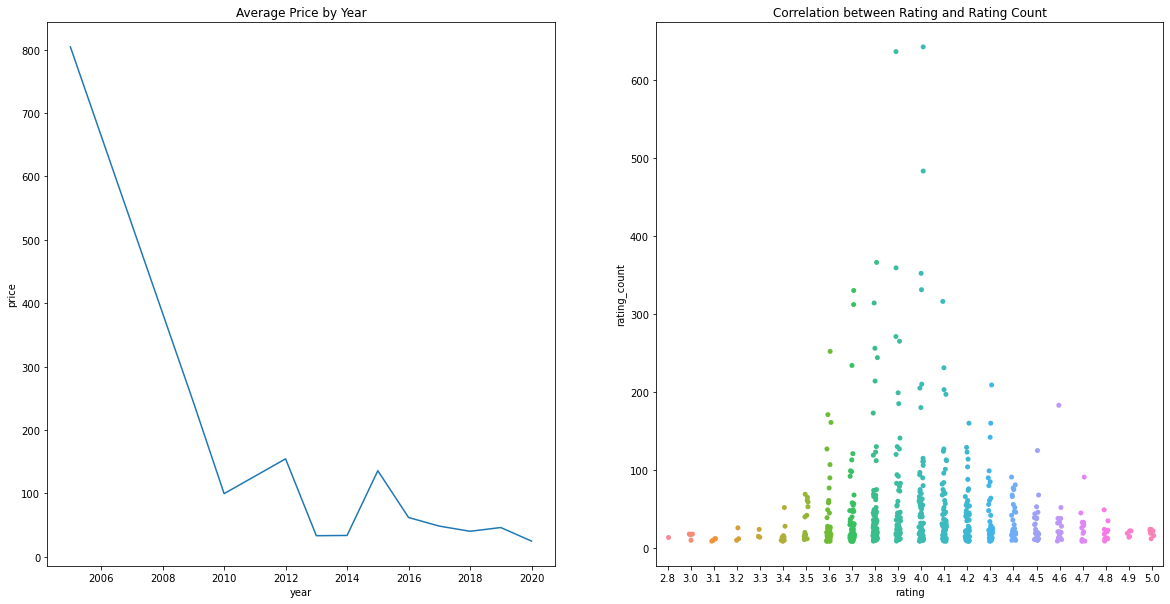

In [32]:
price_by_year = df.groupby('year')['price'].mean().reset_index()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.lineplot(x=price_by_year['year'], y=price_by_year['price'], ax=ax1)
ax1.set_title('Average Price by Year')
sns.stripplot(data=df, x="rating", y="rating_count",ax=ax2)
ax2.set_title('Correlation between Rating and Rating Count')
plt.show()

### The older the wine, the higher the price

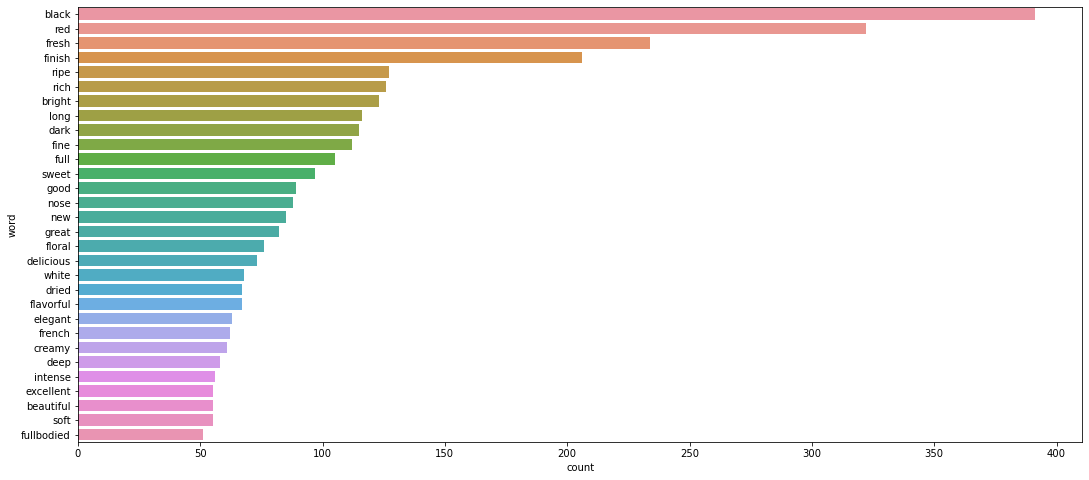

In [33]:
plt.figure(figsize=(18,8))

stop_words = set(stopwords.words("english"))
reviews = df['reviews']
reviews_tokens = reviews.apply(word_tokenize)

filtered_reviews = []
for review in reviews_tokens:
    tagged_words = pos_tag(review)
    adjectives = [word for word, pos in tagged_words if pos == 'JJ']
    filtered_reviews.append(adjectives)

all_words = [word for sublist in filtered_reviews for word in sublist]
fdist = nltk.FreqDist(all_words)
fdist_df = pd.DataFrame(fdist.most_common(30), columns=['word', 'count'])

sns.barplot(x='count', y='word', data=fdist_df)
plt.show()

### Most commonly used adjectives

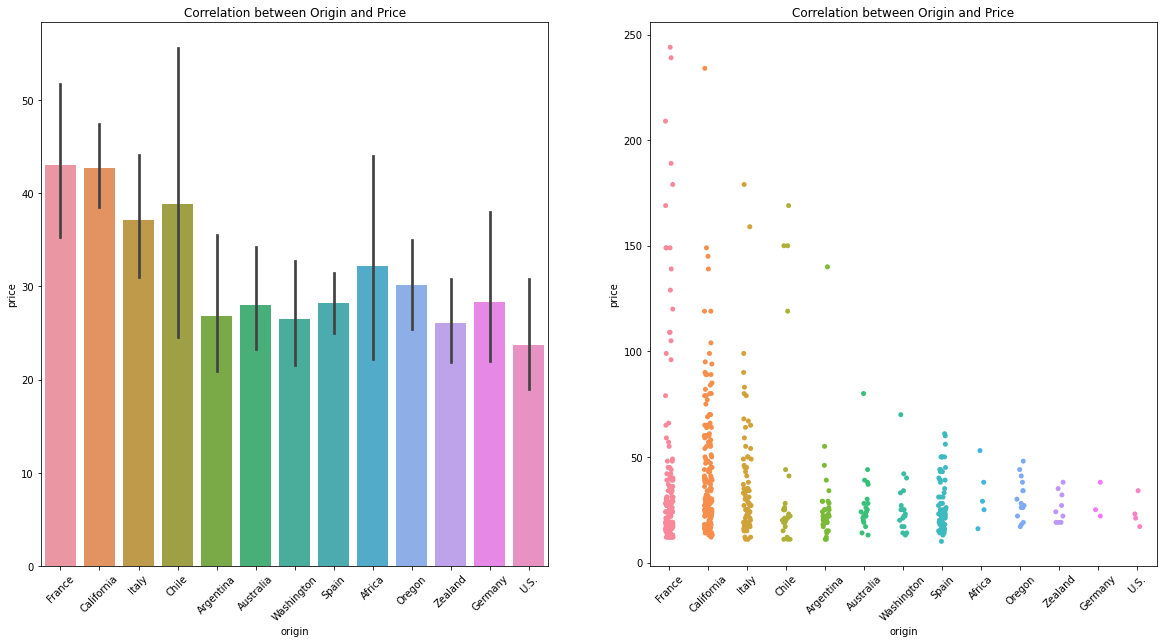

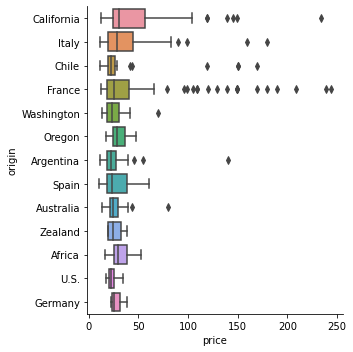

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
df_filtered = df.drop(df[df.price >= 250].index)
df_filtered = df_filtered.sort_values(by='price', ascending=False)
sns.barplot(x = 'origin', y = 'price', data = df_filtered,ax=ax1)
sns.stripplot(data=df_filtered, x="origin", y="price",ax=ax2)
ax1.set_title('Correlation between Origin and Price')
ax2.set_title('Correlation between Origin and Price')

sns.catplot(data=df.drop(df[df.price >= 250].index), x="price", y="origin",kind="box")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

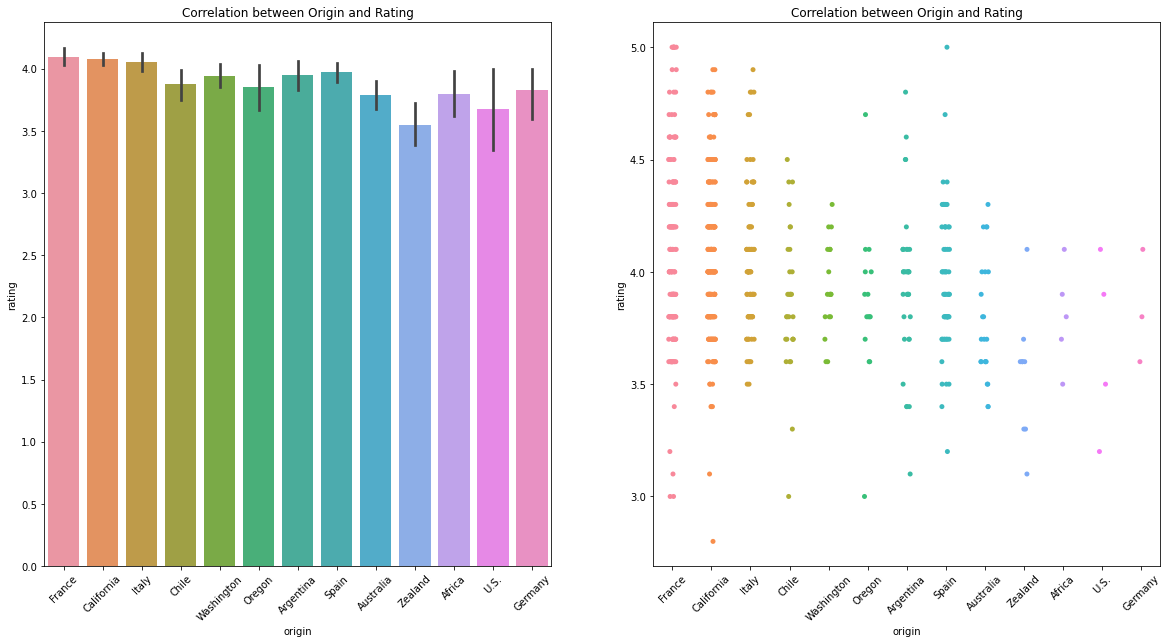

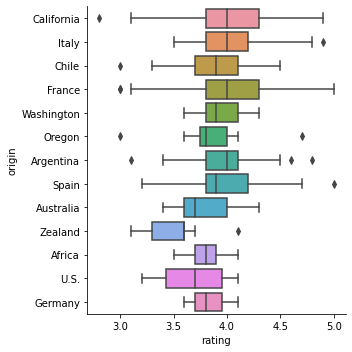

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'rating', data = df,ax=ax1)
sns.stripplot(data=df, x="origin", y="rating",ax=ax2)
ax1.set_title('Correlation between Origin and Rating')
ax2.set_title('Correlation between Origin and Rating')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="rating", y="origin",kind="box")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

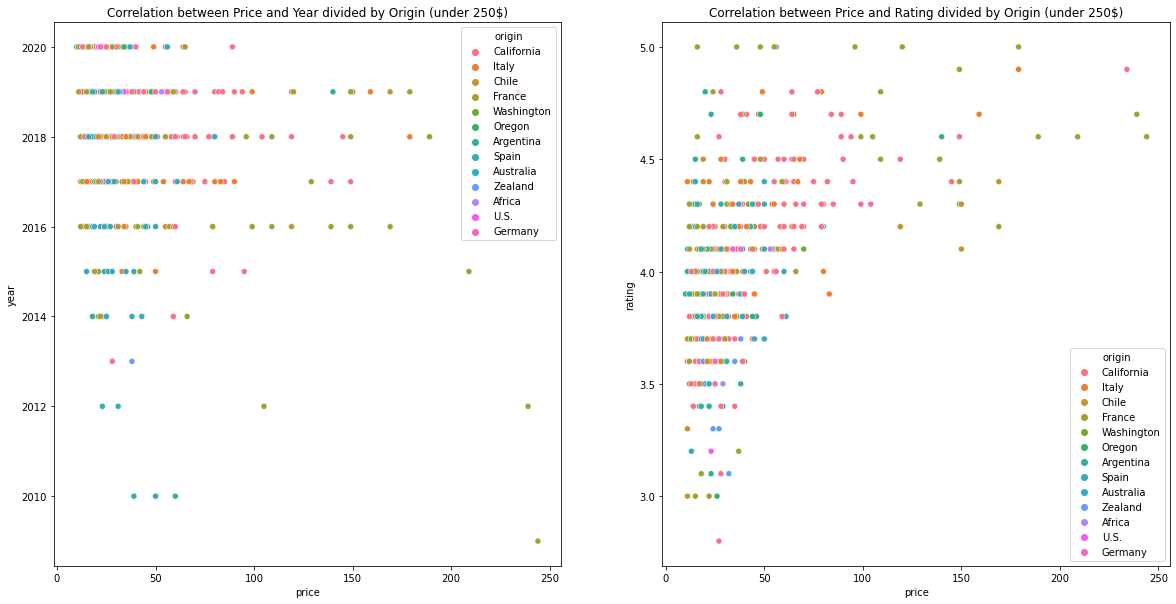

In [36]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="year",hue="origin",ax =ax1)
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="rating",hue="origin",ax =ax2)
ax1.set_title('Correlation between Price and Year divided by Origin (under 250$)')
ax2.set_title('Correlation between Price and Rating divided by Origin (under 250$)')
plt.show()

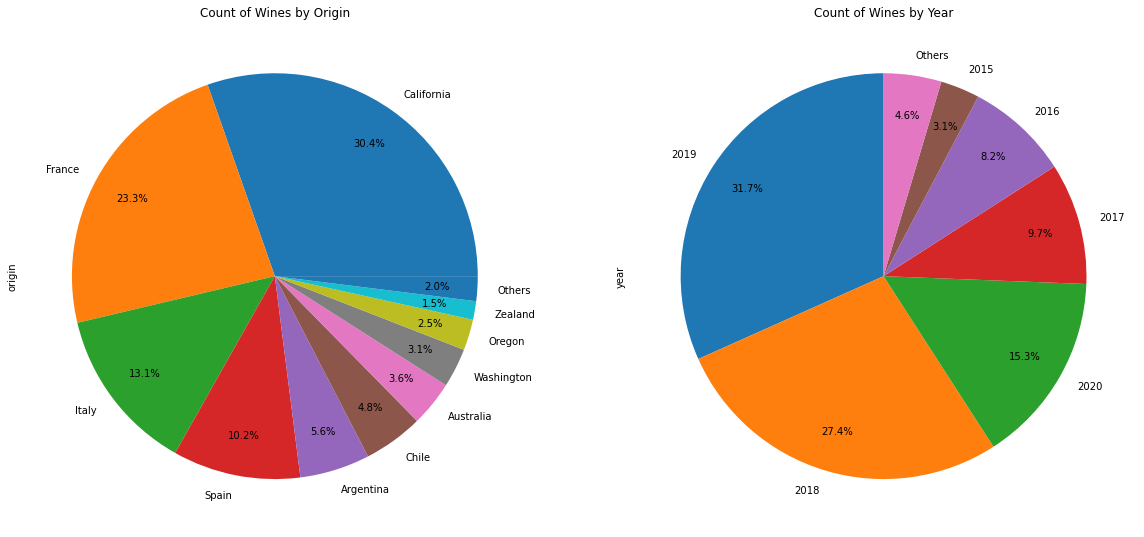

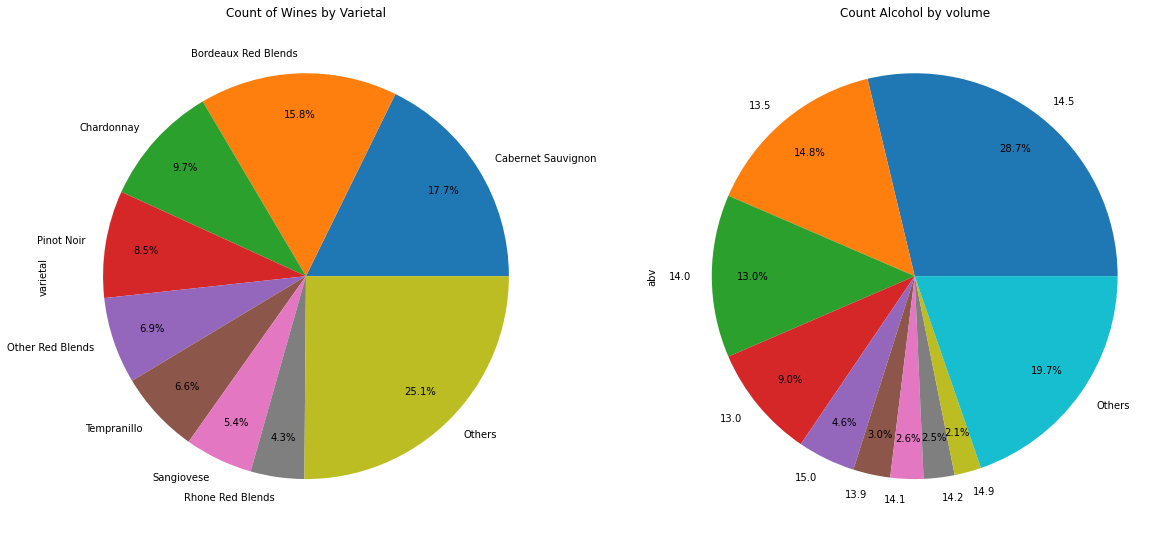

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
fig1, (ax3,ax4) = plt.subplots(1,2, figsize=(20,10))

df_origin = df['origin'].value_counts()
others = df_origin[df_origin <= df_origin.sum() * 0.01].sum()
df_origin = df_origin[df_origin > df_origin.sum() * 0.01]
df_origin['Others'] = others
df_origin.plot.pie(y='origin', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax1)

df_year = df['year'].value_counts()
others = df_year[df_year <= df_year.sum() * 0.02].sum()
df_year = df_year[df_year > df_year.sum() * 0.02]
df_year['Others'] = others
df_year.plot.pie(y='year', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax2,startangle=90)

df_varietal = df['varietal'].value_counts()
others = df_varietal[df_varietal <= df_varietal.sum() * 0.04].sum()
df_varietal = df_varietal[df_varietal > df_varietal.sum() * 0.04]
df_varietal['Others'] = others
df_varietal.plot.pie(figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax3)

df_abv = df['abv'].value_counts()
others = df_abv[df_abv <= df_abv.sum() * 0.02].sum()
df_abv = df_abv[df_abv > df_abv.sum() * 0.02]
df_abv['Others'] = others
df_abv.plot.pie(figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax4)

ax1.set_title("Count of Wines by Origin")
ax2.set_title('Count of Wines by Year')
ax3.set_title('Count of Wines by Varietal')
ax4.set_title('Count Alcohol by volume')
plt.show()

### Most of the wine is made in California
### Most of the wine is produced in 2019
### The most common varietal is Cabernet Sauvignon
### Most of the wine has 14.5% alcohol

**---------------------------------------------------------------------------------------------------------------------------**

# Regression vs. Classification

# Setting up everything for machine learning (Regression)

**Divide into independent and dependent variables**

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df.drop(columns=['rating','product_name','varietal','origin','reviews'])
vectorizer = TfidfVectorizer()
reviews = vectorizer.fit_transform(df['reviews'])
X = np.concatenate((reviews.toarray(), X), axis=1)
y = df['rating']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Classify function takes a model, a set of training data (x_train and y_train), and a set of test data (x_test and y_test) as input, and it performs several tasks related to evaluating the performance of the model**

In [39]:
def classify(model, x_train, x_test, y_train, y_test):
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    y_pred = model.predict(x_test)
    # evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    print("CV Score:", np.mean(score)*-1)
    plt.scatter(y_pred, y_test, c='red', alpha=0.5, s=50, label='Predicted values')
    plt.scatter(y_test, y_pred, c='blue', alpha=0.5, s=50, label='True values')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title('Predicted vs. true values')
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    plt.show()
    return model, y_pred, mae

# Starting machine learning (Regression)

**Linear Regression**

Accuracy: -6.857970536521951
Mean Absolute Error: 0.29330520798526355
CV Score: 0.2883416191974414


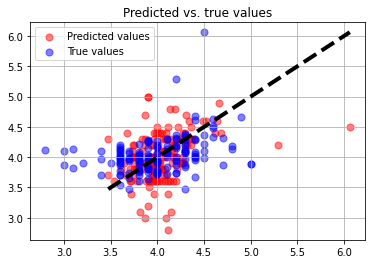

In [40]:
from sklearn.linear_model import LinearRegression
LinearRegression = LinearRegression()
trained_model, y_pred_lr , accuracy_lr = classify(LinearRegression, x_train, x_test, y_train, y_test)

**Decision Tree Regressor**

Accuracy: -7.444798543136821
Mean Absolute Error: 0.31111111111111106
CV Score: 0.30324210811543156


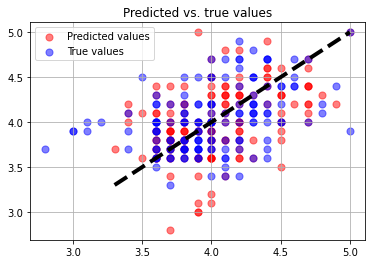

In [41]:
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor = DecisionTreeRegressor()
trained_model, y_pred_dt , accuracy_dt = classify(DecisionTreeRegressor, x_train, x_test, y_train, y_test)

**Random Forest Regressor**

Accuracy: 36.08243893694515
Mean Absolute Error: 0.23196078431372535
CV Score: 0.23498483945264867


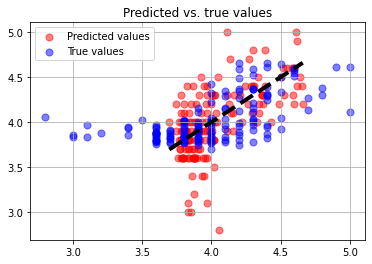

In [42]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()
trained_model, y_pred_rf , accuracy_rf = classify(random_forest, x_train, x_test, y_train, y_test)

**Extra Trees Regressor**

Accuracy: 34.110125967448155
Mean Absolute Error: 0.23863398692810459
CV Score: 0.23473231269475683


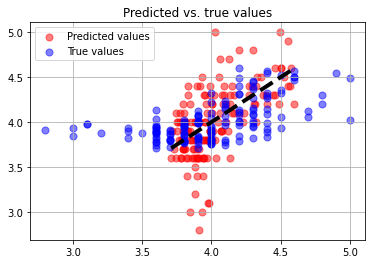

In [43]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor()
trained_model, y_pred_et , accuracy_et = classify(extra_trees_model, x_train, x_test, y_train, y_test)

**SVR**

Accuracy: 9.640922171475063
Mean Absolute Error: 0.2761160475826973
CV Score: 0.2806421304374568


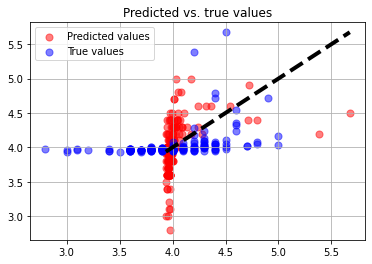

In [44]:
from sklearn.svm import SVR
svr_model = SVR()
trained_model, y_pred_sv , accuracy_sv = classify(svr_model, x_train, x_test, y_train, y_test)

**We are unable to use those models because they are inaccurate. We will try to find a new approach!**

# Setting up everything for machine learning (Classification)

**Create a new column called quality in the DataFrame, which contains the labels for the categories that each value in the rating column belongs to**

In [45]:
df['rating'].value_counts()
names = ['poor', 'high']
bins = (3.0, 4.1, 5.0)
df['quality'] = pd.cut(df['rating'], bins = bins, labels = names)

**Display a bar chart that shows the counts of each category in the quality column of the DataFrame**

Text(0.5, 1.0, 'Quality of Wine')

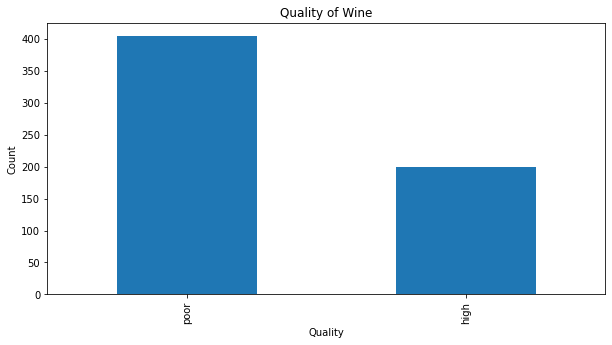

In [46]:
df['quality'].value_counts().plot.bar(figsize=(10, 5))
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Quality of Wine')

**Convert the values in the quality column of the DataFrame to numerical values**

In [47]:
df = df.dropna(subset=['quality'])
df['quality'] = df['quality'].replace({'high': 1, 'poor': 0})
df['quality'] = df['quality'].astype(int)
df

C:\Users\Ariel\AppData\Local\Temp/ipykernel_22080/2090294129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quality'] = df['quality'].replace({'high': 1, 'poor': 0})
C:\Users\Ariel\AppData\Local\Temp/ipykernel_22080/2090294129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quality'] = df['quality'].astype(int)


,product_name,year,varietal,origin,price,abv,rating,rating_count,reviews,varietal_code,origin_code,quality
0,Dom Perignon Vintage with Gift Box,2012,Vintage Sparkling Wine,France,269,12.0,4.8,49,what a magnificent bouquet for this dom pérign...,28,5,1
1,Duckhorn Napa Valley Cabernet Sauvignon,2019,Cabernet Sauvignon,California,80,14.5,4.3,80,commentary the 2019 duckhorn vineyards caberne...,4,3,1
2,Opus One,2019,Bordeaux Red Blends,California,389,13.5,4.9,15,the purity of fruit is really something else h...,1,3,1
3,Silver Oak Alexander Valley Cabernet Sauvignon,2018,Cabernet Sauvignon,California,89,14.4,4.7,29,commentary the silver oak alexander valley one...,4,3,1
4,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,82,14.5,4.4,91,cassis dried blueberries violets ink graphite ...,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
604,Vinaceous Reverend V Chardonnay,2016,Chardonnay,Australia,24,13.0,3.8,14,the team behind this brand including the winem...,6,2,0
605,J Wilkes Pinot Noir,2018,Pinot Noir,California,29,13.5,3.9,11,lastly the 2018 pinot noir j wilkes santa mari...,19,3,0
606,Masut Estate Vineyard Pinot Noir,2017,Pinot Noir,California,39,14.5,3.6,10,lithe pure and richtasting with concentrated d...,19,3,0
607,Tenuta di Nozzole Villa Nozzole Chianti Classico,2018,Sangiovese,Italy,21,13.6,3.7,9,a fresh lively red with plums tile and hints o...,22,7,0


**Divide into independent and dependent variables**

In [48]:
X = df.drop(columns=['rating','product_name','varietal','origin','quality', 'reviews'])
vectorizer = TfidfVectorizer()
reviews = vectorizer.fit_transform(df['reviews'])
X = np.concatenate((reviews.toarray(), X), axis=1)
y = df['quality']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Classify function takes a model, a set of training data (x_train and y_train), and a set of test data (x_test and y_test) as input, and it performs several tasks related to evaluating the performance of the model**

In [49]:
def classify(model, x_train, x_test, y_train, y_test):
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    y_pred = model.predict(x_test)
    
    # cross-validation
    score = cross_val_score(model, X, y, cv=5)
    print("CV Score:", np.mean(score)*100)
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, columns=['0', '1'])
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.figure(figsize=(5,5))
    plt.show()
    
    return model, y_pred, accuracy

In [50]:
models = []
models_accuracies = []


# Starting machine learning (Classification)

**Logistic Regression**

Accuracy: 78.1456953642384
CV Score: 79.95730027548208


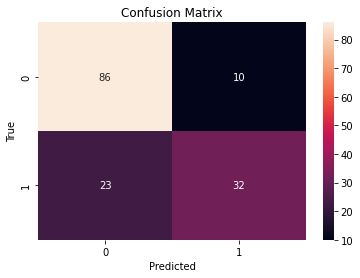

<Figure size 360x360 with 0 Axes>

In [51]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=500)
trained_model, y_pred_lr , accuracy_lr = classify(logistic_regression, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Decision Tree Classifier**

Accuracy: 74.83443708609272
CV Score: 74.16391184573004


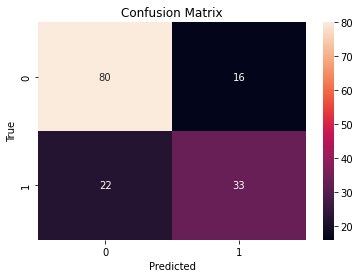

<Figure size 360x360 with 0 Axes>

In [52]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
trained_model, y_pred_dt , accuracy_dt = classify(decision_tree, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_dt)

**Random Forest Classifier**

Accuracy: 73.50993377483444
CV Score: 75.32506887052342


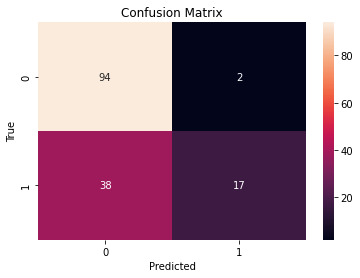

<Figure size 360x360 with 0 Axes>

In [53]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
trained_model, y_pred_rf , accuracy_rf = classify(random_forest, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_rf)

**Extra Trees Classifier**

Accuracy: 70.86092715231787
CV Score: 72.67906336088154


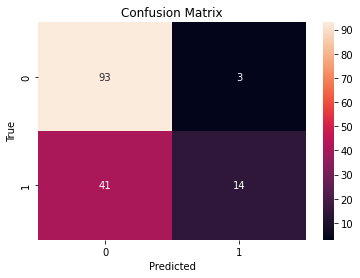

<Figure size 360x360 with 0 Axes>

In [54]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_model = ExtraTreesClassifier()
trained_model, y_pred_et , accuracy_et = classify(extra_trees_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_et)

**AdaBoost**

Accuracy: 76.82119205298014
CV Score: 73.5137741046832


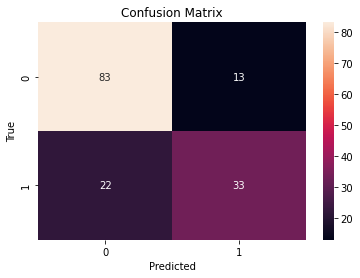

<Figure size 360x360 with 0 Axes>

In [55]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
trained_model, y_pred_ada , accuracy_ada = classify(ada_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_ada)

**Gradient Boosting**

Accuracy: 79.47019867549669
CV Score: 77.47520661157026


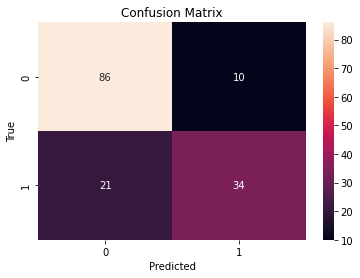

<Figure size 360x360 with 0 Axes>

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier()
trained_model, y_pred_gbc , accuracy_gbc = classify(gbc_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_gbc)

**LightGBM**

Accuracy: 79.47019867549669
CV Score: 76.81129476584022


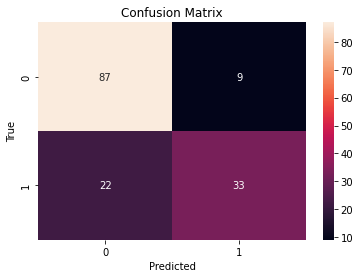

<Figure size 360x360 with 0 Axes>

In [57]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier()
trained_model, y_pred_lgbm , accuracy_lgbm = classify(lgbm_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lgbm)

**Multi-layer Perceptron classifier**

Accuracy: 76.15894039735099
CV Score: 74.66528925619835


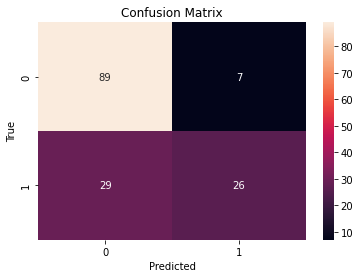

<Figure size 360x360 with 0 Axes>

In [58]:
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(max_iter=1000)
trained_model, y_pred_lr , accuracy_lr = classify(nn_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Support Vector Classifier**

Accuracy: 78.1456953642384
CV Score: 78.30303030303031


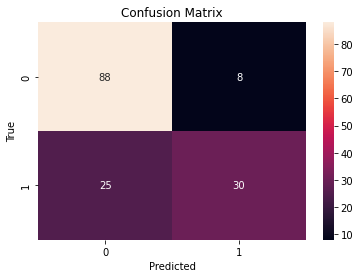

<Figure size 360x360 with 0 Axes>

In [59]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
trained_model, y_pred_lr , accuracy_lr = classify(svm_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Naive Bayes**

Accuracy: 56.29139072847682
CV Score: 59.10192837465564


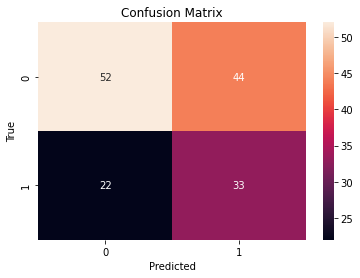

<Figure size 360x360 with 0 Axes>

In [60]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
trained_model, y_pred_nb , accuracy_nb = classify(nb_model, x_train, x_test, y_train, y_test)
models.append(trained_model)
models_accuracies.append(accuracy_nb)

**Display a summary of the results of training and evaluating several machine learning models**

In [61]:
models_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting', 'LightGBM', 'MLP', 'SVC', 'Naive Bayes']
for model, acc in zip(models_names, models_accuracies):
    print(f'Model: {model}, score: {acc} ')

Model: Logistic Regression, score: 0.7814569536423841 
Model: Decision Tree, score: 0.7483443708609272 
Model: Random Forest, score: 0.7350993377483444 
Model: Extra Trees, score: 0.7086092715231788 
Model: AdaBoost, score: 0.7682119205298014 
Model: Gradient Boosting, score: 0.7947019867549668 
Model: LightGBM, score: 0.7947019867549668 
Model: MLP, score: 0.7615894039735099 
Model: SVC, score: 0.7814569536423841 
Model: Naive Bayes, score: 0.5629139072847682 


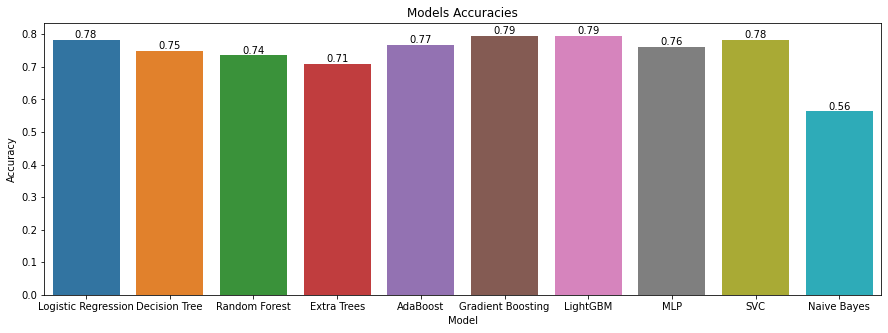

In [62]:
plt.figure(figsize=(15,5))
sns.barplot(x=models_names, y=models_accuracies)
for i, v in enumerate(models_accuracies):
    plt.text(i, v, f"{v:.2f}", va="bottom", ha="center")
plt.title('Models Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

**Contain the trained machine learning model that achieved the highest accuracy score among all of the models in the models list**

In [63]:
max_index = models_accuracies.index(max(models_accuracies))
best_model = models[max_index]
best_model

GradientBoostingClassifier()